In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import utils
import torch

from einops import rearrange, reduce, repeat

from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

In [48]:
subjs = utils.ExpInfo.getSubjIDs()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

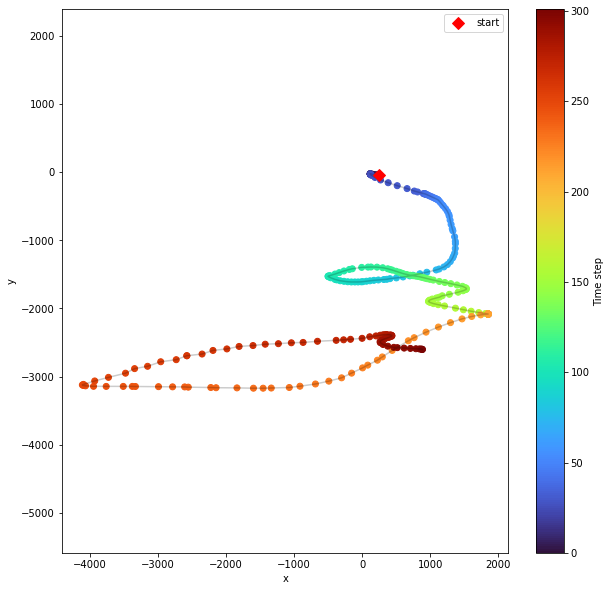

In [21]:
# model = utils.Model.load().eval()
model = utils.Model.load(path='TrajNet_train_60s').eval()

subj = utils.ExpInfo.getSubjIDs()[7]
task = utils.ExpInfo.taskName[0]
trialno = 14
df = utils.LoadData.mouseMovement(subj, task, trialno)
x = utils.DataProcessing.rollingWindow_from_df(df, 40, 1)
y = model(torch.from_numpy(x).double())
h = model.model.x_hidden.detach().cpu().numpy()

d_trial = df[["x-shift", "y-shift"]].values
d_trial_cum = d_trial.cumsum(axis=0)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
utils.Plot.traj_withColour(d_trial_cum[:, 0], d_trial_cum[:, 1], fig, ax)

/home/acercyc/anaconda3/envs/py38/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

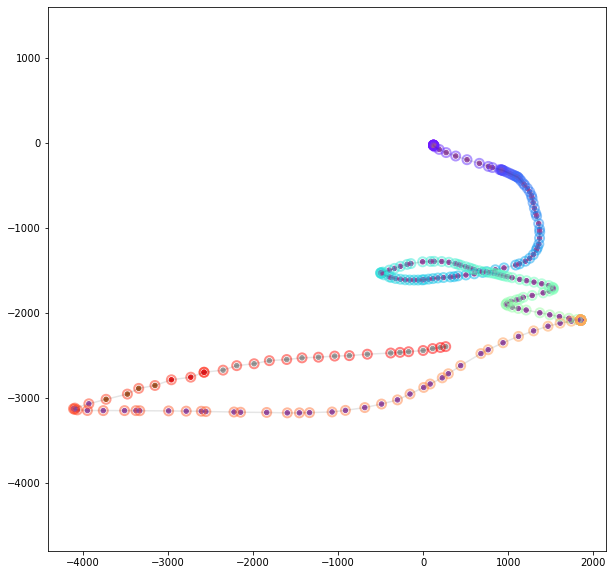

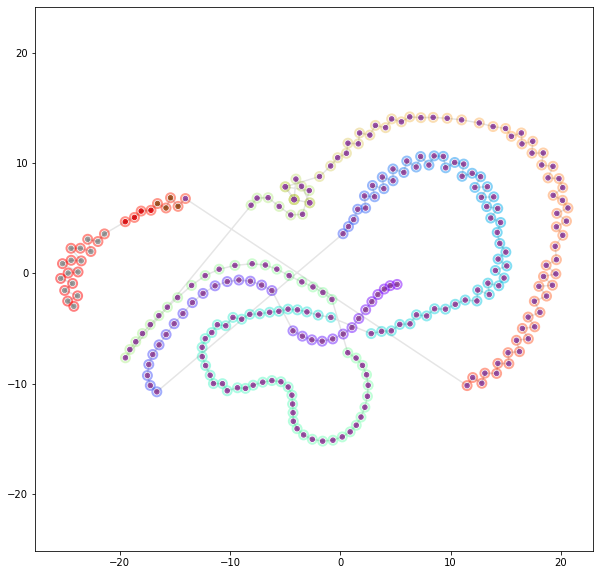

In [22]:
# use numpy to generate 10 data points in 4 clusters
# d = StandardScaler().fit_transform(d_trial_cum)
# clustering = DBSCAN(eps=0.2, min_samples=2).fit(d)


def plot_clusters(x, y, labels, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    cmap = mpl.cm.get_cmap('rainbow')
    edgecolors = cmap(range(len(x)))
    ax.plot(x, y, 'k', alpha=0.1)
    ax.scatter(x, y, c=labels, s=20, cmap='Set1', alpha=1)
    ax.scatter(x, y, s=80, edgecolors=edgecolors,
               linewidths=2, facecolors='none', alpha=0.5)
    # ax.scatter(x, y, s=80, c=labels, cmap='tab10', linewidths=2, facecolors='none', alpha=1)
    # ax.scatter(x, y, c=edgecolors, s=20, alpha=0.8, cmap='turbo')
    ax.axis('equal')
    if ax is None:
        return fig, ax


nTime = h.shape[0]
# d_trial = df[["x-shift", "y-shift"]].values
# d_trial_cum = d_trial.cumsum(axis=0)
# x = d_flat


def clustering_embedding(x, embedding=True):
    from sklearn.cluster import OPTICS, SpectralClustering
    from sklearn.mixture import GaussianMixture

    # x = StandardScaler().fit_transform(x)
    labels = DBSCAN(eps=0.6, min_samples=4, metric='euclidean').fit_predict(x)
    # labels = OPTICS(min_samples=5, metric='minkowski').fit_predict(x)
    # labels = GaussianMixture(n_components=4, random_state=0).fit_predict(x)

    # labels = SpectralClustering(n_clusters=4,
    #                             assign_labels='discretize',
    #                             random_state=0).fit_predict(x)
    if embedding:
        x = TSNE(n_components=2, learning_rate='auto',
                 init='pca').fit_transform(x)
        return labels, x
    else:
        return labels


labels, x_embedded = clustering_embedding(h, embedding=True)
y = d_trial_cum[15:nTime+15, :]
plot_clusters(y[:, 0], y[:, 1], labels)
y = x_embedded
plot_clusters(y[:, 0], y[:, 1], labels)
labels


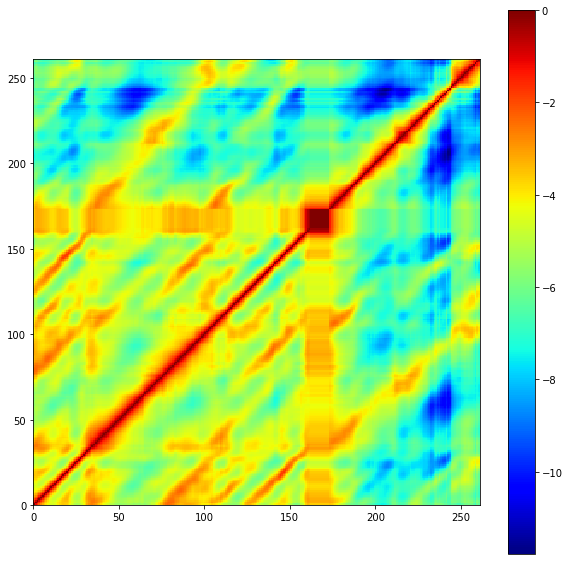

In [35]:
from scipy.spatial import distance
# measure = 'manhattan'
measure = 'seuclidean'
# measure = 'correlation'
Y = distance.pdist(h, measure)
Y = distance.squareform(Y)
Y = -Y
fig, ax = plt.subplots(1, 1, figsize=(10,10))
im = ax.pcolormesh(Y, cmap='jet')
plt.colorbar(im)
ax.set_aspect('equal')

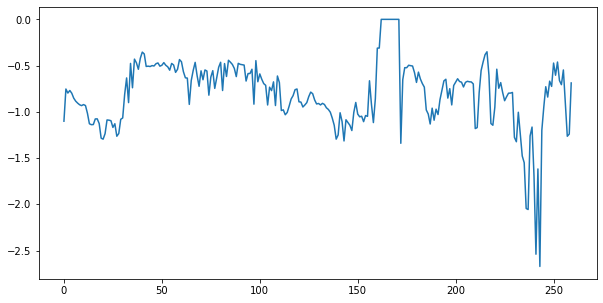

In [39]:
diff = np.diagonal(Y, offset=1)
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(diff)

<BarContainer object of 16 artists>

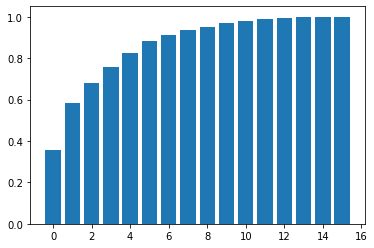

In [46]:
import sklearn.decomposition
pca = sklearn.decomposition.PCA()
pca.fit_transform(h)
n = len(pca.explained_variance_ratio_)
plt.bar(range(n), pca.explained_variance_ratio_.cumsum())